**Plan of the work:**

1)take model

2)take default CIFAR100 dataset

3)for fixed n_epochs measure acc after adv training 

4)construct dataset from CIFAR100 with following changes:

*   for hard classes - add their augmented images to the default dataset

5)for fixed n_epochs measure acc after adv training 

6)compare results from 3 and 5.

In [1]:
from torchvision import datasets, models, transforms
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
import torch



data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [2]:
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

In [3]:
NUM_CLASSES = 100

from tqdm import tqdm 
import torch.nn.functional as F

def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=None):

    max_loss = torch.zeros(y.shape[0]).to(device)
    max_delta = torch.zeros_like(X).to(device)
    scaler = torch.cuda.amp.GradScaler()

    for _ in range(restarts):
        delta = torch.zeros_like(X).to(device)
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True

        for _ in range(attack_iters):
            with torch.cuda.amp.autocast():
                output = model(X + delta)
                index = torch.where(output.max(1)[1] == y)[0]
                if len(index) == 0:
                    break
                loss = F.cross_entropy(output, y)
            scaler.scale(loss).backward()
            grad = delta.grad.detach()

            d = delta[index, :, :, :]
            g = grad[index, :, :, :]
            d = clamp(d + alpha * torch.sign(g), -epsilon, epsilon)
            d = clamp(d, lower_limit - X[index, :, :, :], upper_limit - X[index, :, :, :])

            delta.data[index, :, :, :] = d
            delta.grad.zero_()

        all_loss = F.cross_entropy(model(X + delta), y, reduction='none').detach()
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta


def evaluate_pgd(test_loader, model, attack_iters, restarts, epsilon, alpha, lower_limit, upper_limit, args=None):

    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}

    pgd_loss, pgd_acc = 0, 0
    n = 0
    model.eval()
    for i, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        pgd_delta = attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=args)
        with torch.no_grad():
            output = model(X + pgd_delta)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            pgd_loss += loss.item() * y.size(0)
            pgd_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
    acc_per_class = {}
    for i in range(NUM_CLASSES):
      if examples_per_class[i]:
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
      else:
        acc_per_class[i] = -1
    return pgd_loss/n, pgd_acc/n,acc_per_class


def evaluate_standard(test_loader, model, args=None):
    
    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}
    
    test_loss, test_acc = 0, 0
    n = 0
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)
            output = model(X)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            test_loss += loss.item() * y.size(0)
            test_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
    acc_per_class = {}
    for i in range(NUM_CLASSES):
      if examples_per_class[i]:
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
      else:
        acc_per_class[i] = -1
    return test_loss/n, test_acc/n,acc_per_class


In [4]:
data_dir = 'cifar-100'

In [5]:
train_transform = transforms.Compose([
        #transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3,0.6),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_dataset1 = datasets.CIFAR100(data_dir, train=True, transform=train_transform, download=True)
train_dataset2 = datasets.CIFAR100(data_dir, train=True, transform=test_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


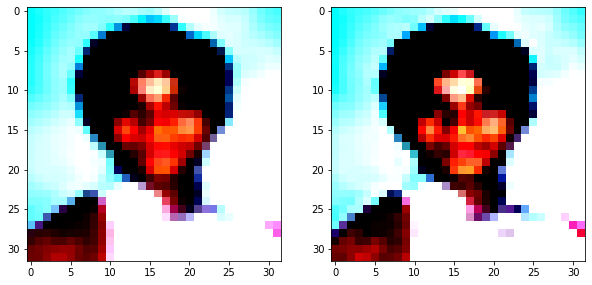

In [6]:
import numpy as np
import matplotlib.pyplot as plt

a1 = np.array(train_dataset1[3][0]).transpose(1,2,0)
a2 = np.array(train_dataset2[3][0]).transpose(1,2,0)


fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(a1)
axes[1].imshow(a2)

In [7]:
import torch.nn as nn

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if (stride != 1) or (in_planes != self.expansion * planes):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if (stride != 1) or (in_planes != self.expansion * planes):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.bn = nn.BatchNorm2d(512 * block.expansion)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18(num_classes=10):
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes)

In [8]:
hard_classes = [13,35,55,72,96,10,44,65,74,4]
easy_classes = [8,9,20,87,94,21,41,39,53,68]

hard_classes.index(55)

2

In [9]:
X_all,y_all = train_dataset1.data, torch.LongTensor(train_dataset1.targets)
X_all_sampled, y_all_sampled = [], []

for c in torch.unique(y_all):
    X_all_c, y_all_c = X_all[y_all==c], y_all[y_all==c]
    
    if c in hard_classes:
        num_samples = len(X_all_c)
        sampled_indices = torch.randperm(num_samples)
        X_all_sampled.append(X_all_c[sampled_indices])
        y_all_sampled.append(torch.LongTensor([hard_classes.index(c)]*num_samples))
        
    
X_all_sampled = np.concatenate(X_all_sampled, axis=0)
y_all_sampled = list(torch.cat(y_all_sampled, dim=0))

print(X_all_sampled.shape)

(5000, 32, 32, 3)


In [10]:
class Extra_Dataset(torch.utils.data.Dataset):

  def __init__(self,x,y):
    self.x = x.astype(np.float32)
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    x = (self.x)[idx]
    y = (self.y)[idx]
    return x,y

In [11]:
extra_dataset = Extra_Dataset(X_all_sampled.transpose(0,3,1,2),y_all_sampled)

In [12]:
train_transform = test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_dataset = datasets.CIFAR100(
        'cifar_base_test', train=False, transform=train_transform, download=True
    )

train_loader1 = torch.utils.data.DataLoader(
    dataset=extra_dataset,
    batch_size=32, shuffle=True,
    pin_memory=True,drop_last=True
)

train_loader2 = torch.utils.data.DataLoader(
    dataset=train_dataset2,
    batch_size=32, shuffle=True,
    pin_memory=True,drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32, shuffle=True,
    pin_memory=True,drop_last=True
)

Files already downloaded and verified


In [13]:
def unite_iters(*itrs):
    for itr in itrs:
        for v in itr:
            yield v


train_loader = unite_iters(train_loader1,train_loader2)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

weight_decay = 5e-4
epsilon = 8
batch_size = 32
alpha = 2
loss_weight = 0.1
fgsm_step = 1
delta_init = 'random'
model = PreActResNet18(num_classes=100).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()

data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

mu = torch.tensor(data_mean).view(3, 1, 1).to(device)
std = torch.tensor(data_std).view(3, 1, 1).to(device)
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
epsilon = (epsilon / 255.) / std
alpha = (alpha / 255.) / std

if delta_init == 'previous':
    delta = torch.zeros(batch_size, 3, 32, 32).to(device)

prev_robust_acc = 0.

cuda


In [15]:
acc_train_history = []
acc_pgd_val_history = []
acc_st_val_history = []

In [16]:
print(len(train_loader1)*32)
print(len(train_loader2)*32)

4992
49984


In [17]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
loop = tqdm(range(epochs))
for epoch in loop:
    train_loss,train_acc,train_n = 0,0,0
    if epoch > 12:
      optimizer.param_groups[0]['lr'] = 1e-4
    model.train()
    for train_loader in [train_loader1,train_loader2]:
        for i, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            if delta_init != 'previous':
                delta = torch.zeros_like(X).to(device)
            if delta_init == 'random':
                for j in range(len(epsilon)):
                    delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
                delta.data = clamp(delta, lower_limit - X, upper_limit - X)
            if fgsm_step == 1:
                delta.requires_grad = True
                for _ in range(1):
                    output = model(X + delta[:X.size(0)])
                    loss = F.cross_entropy(output, y)
                    scaler.scale(loss).backward()
                    grad = delta.grad.detach()
                    scaler.step(optimizer)
                    scaler.update()
                    delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                    delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
                delta = delta.detach()
                output = model(X + delta[:X.size(0)])
                loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                  
            train_loss += loss.item() * y.size(0)
            train_acc += (output.max(1)[1] == y).sum().item()
            train_n += y.size(0)
      
    acc_train_history.append(train_acc/train_n)
    model.eval()
    pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loader, model, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
    acc_pgd_val_history.append(pgd_acc)
    st_loss, st_acc, acc_cl_st_at = evaluate_standard(test_loader, model)
    acc_st_val_history.append(st_acc)
      
    loop.set_description(f'train acc: {round(train_acc / train_n,3)} test acc: {round(pgd_acc,3)}')

train acc: 0.708 test acc: 0.318: 100%|██████████| 20/20 [1:18:52<00:00, 236.61s/it]


In [24]:
print(acc_train_history)
print(acc_pgd_val_history)
print(acc_st_val_history)

[0.10140788707799767, 0.17620416181606519, 0.24068684516880093, 0.28257785215366704, 0.31802968568102447, 0.34040308498253785, 0.36277648428405124, 0.3780558789289872, 0.3945539871944121, 0.4082144935972061, 0.4206744761350407, 0.43400756693830034, 0.4435389988358556, 0.5515497671711292, 0.5939682770663562, 0.6254547438882422, 0.6509931606519208, 0.6724206926658906, 0.6941938300349243, 0.7075087310826542]
[0.14873798076923078, 0.21264022435897437, 0.26953125, 0.30448717948717946, 0.33052884615384615, 0.33994391025641024, 0.3503605769230769, 0.3564703525641026, 0.3492588141025641, 0.3622796474358974, 0.3495592948717949, 0.3529647435897436, 0.35216346153846156, 0.3766025641025641, 0.36217948717948717, 0.35076121794871795, 0.33653846153846156, 0.3245192307692308, 0.323818108974359, 0.3184094551282051]
[0.19571314102564102, 0.2920673076923077, 0.3864182692307692, 0.444911858974359, 0.48647836538461536, 0.5094150641025641, 0.5285456730769231, 0.5347556089743589, 0.5300480769230769, 0.546173

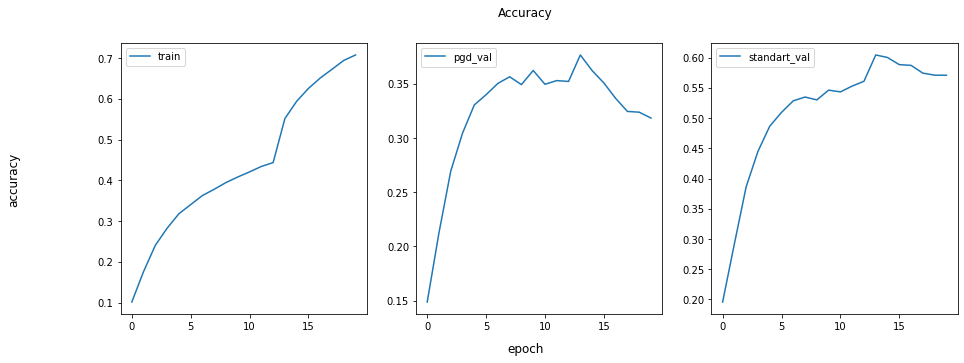

In [27]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

plt.suptitle('Accuracy')
fig.supxlabel('epoch')
fig.supylabel('accuracy')

axes[0].plot(range(epochs),acc_train_history[-20:],label='train')
axes[0].legend()
axes[1].plot(range(epochs),acc_pgd_val_history[-20:],label='pgd_val')
axes[1].legend()
axes[2].plot(range(epochs),acc_st_val_history[-20:],label='standart_val')
axes[2].legend()